<a href="https://colab.research.google.com/github/aguilarmadeira/Optimization/blob/main/Mallows_inica%C3%A7%C3%A3o_inteligente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 1, Best distance: 10174.78


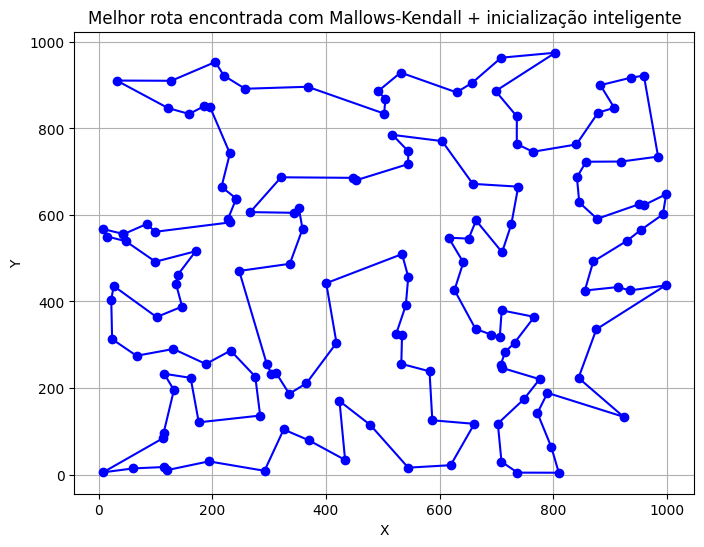

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mallows_kendall as mk

# Representação das cidades
class City:
    def __init__(self):
        self.x = np.random.uniform(0, 1000)
        self.y = np.random.uniform(0, 1000)

    def distance(self, city):
        return np.hypot(self.x - city.x, self.y - city.y)

# Classe para o TSP
class TSP:
    def __init__(self, num_cities):
        self.cities = [City() for _ in range(num_cities)]

    def tour_distance(self, perm):
        return sum(self.cities[perm[i]].distance(self.cities[perm[(i + 1) % len(perm)]])
                   for i in range(len(perm)))

# Escolha inicial das cidades mais distantes
def escolher_cidades_distantes(problem, num_inicial):
    escolhidas = []

    # Duas cidades mais distantes inicialmente
    maior_distancia = -1
    for i in range(len(problem.cities)):
        for j in range(i + 1, len(problem.cities)):
            d = problem.cities[i].distance(problem.cities[j])
            if d > maior_distancia:
                maior_distancia = d
                escolhidas = [i, j]

    # Adiciona as cidades seguintes, maximizando a distância mínima para já escolhidas
    while len(escolhidas) < num_inicial:
        max_min_dist = -1
        proxima = None
        for idx in range(len(problem.cities)):
            if idx in escolhidas:
                continue
            min_dist = min(problem.cities[idx].distance(problem.cities[sel]) for sel in escolhidas)
            if min_dist > max_min_dist:
                max_min_dist = min_dist
                proxima = idx

        escolhidas.append(proxima)

    return escolhidas

# Inserção incremental da nova cidade com mínimo impacto
def inserir_minimo_custo(problem, rota, cidade_idx):
    menor_aumento = float('inf')
    melhor_pos = None
    cidade_nova = problem.cities[cidade_idx]

    for i in range(len(rota)):
        atual = problem.cities[rota[i]]
        prox = problem.cities[rota[(i + 1) % len(rota)]]

        aumento = (atual.distance(cidade_nova) + cidade_nova.distance(prox)
                   - atual.distance(prox))

        if aumento < menor_aumento:
            menor_aumento = aumento
            melhor_pos = i + 1

    rota.insert(melhor_pos, cidade_idx)

# Solucionador TSP com Mallows-Kendall
class MallowsKendallTSP:
    def __init__(self, num_cities, phi=0.8, m_samples=20, num_inicial=20):
        self.problem = TSP(num_cities)
        self.phi = phi
        self.m_samples = m_samples

        # Inicialização inteligente
        self.best_tour = escolher_cidades_distantes(self.problem, num_inicial)

        # Inserção incremental das cidades restantes
        restantes = set(range(num_cities)) - set(self.best_tour)
        for cidade_idx in restantes:
            inserir_minimo_custo(self.problem, self.best_tour, cidade_idx)

        self.best_distance = self.problem.tour_distance(self.best_tour)

    def busca_local_2opt(self, tour):
        improved = True
        while improved:
            improved = False
            for i in range(len(tour) - 1):
                for j in range(i + 2, len(tour)):
                    if j - i == 1: continue
                    new_tour = tour[:i] + tour[i:j][::-1] + tour[j:]
                    if self.problem.tour_distance(new_tour) < self.problem.tour_distance(tour):
                        tour = new_tour
                        improved = True
        return tour

    def optimize(self, iterations=100):
        current_tour = self.best_tour.copy()

        for iteration in range(iterations):
            sampled_tours = mk.sample(m=self.m_samples, n=len(self.problem.cities),
                                      phi=self.phi, s0=current_tour)

            for candidate in sampled_tours:
                candidate = candidate.astype(int).tolist()
                candidate = self.busca_local_2opt(candidate)
                candidate_distance = self.problem.tour_distance(candidate)

                if candidate_distance < self.best_distance:
                    self.best_distance = candidate_distance
                    self.best_tour = candidate.copy()
                    current_tour = candidate.copy()

            print(f"Iteration {iteration+1}, Best distance: {self.best_distance:.2f}")

    def plot_solution(self):
        xs = [self.problem.cities[i].x for i in self.best_tour] + [self.problem.cities[self.best_tour[0]].x]
        ys = [self.problem.cities[i].y for i in self.best_tour] + [self.problem.cities[self.best_tour[0]].y]
        plt.figure(figsize=(8, 6))
        plt.plot(xs, ys, '-o', color='blue')
        plt.title('Melhor rota encontrada com Mallows-Kendall + inicialização inteligente')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()
        plt.show()

# Executando o solucionador
solver = MallowsKendallTSP(num_cities=150, phi=0.8, m_samples=5, num_inicial=15)
solver.optimize(iterations=1)
solver.plot_solution()
